# PPG Feature Extraction and SpO2 Estimation

### Data Dictionary

* **`ecg`**: 3-lead ECG captured at 500Hz
* **`peaks`**: CSV ONLY, annotated in WFDB. The annotated ECG R peak (1 = peak, 0 = no peak)
* **`pleth_1`**: MAX30101 red wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_2`**: MAX30101 infrared wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_3`**: MAX30101 green wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_4`**: MAX30101 red wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_5`**: MAX30101 infrared wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_6`**: MAX30101 green wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`lc_1`**: TAL221 load cell proximal phalanx (first segment) PPG sensor attachment pressure (arbitrary units, 80Hz)
* **`lc_2`**: TAL221 load cell (base segment) PPG sensor attachment pressure (arbitrary units, 80Hz)
* **`temp_1`**: distal phalanx (first segment) PPG sensor temperature (°C, 10Hz)
* **`temp_2`**: proximal phalanx (base segment) PPG sensor temperature in (°C, 10Hz)
* **`temp_3`**: InvenSenseMPU-9250 IMU temperature (°C, 500Hz)
* **`a_x`**: InvenSenseMPU-9250 IMU acceleration in x-direction (g, 500Hz)
* **`a_y`**: InvenSenseMPU-9250 IMU acceleration in y-direction (g, 500Hz)
* **`a_z`**: InvenSenseMPU-9250 IMU acceleration in z-direction (g, 500Hz)
* **`g_x`**: InvenSenseMPU-9250 IMU angular velocity around x-axis (°/s, 500Hz)
* **`g_y`**: InvenSenseMPU-9250 IMU angular velocity around y-axis (°/s, 500Hz)
* **`g_z`**: InvenSenseMPU-9250 IMU angular velocity around z-axis (°/s, 500Hz)
* Each CSV record includes a **`time`** column that was date shifted to de-indentify participants.

## 1. Data Loading & EDA

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from scipy.ndimage import gaussian_filter1d
import sys

In [2]:
# Python file imports
sys.path.append("../src")
from load_data import load_signal_csv, load_metadata_csv, plot_ppg, check_missing_values

In [3]:
# Loading and exploring the data

df = load_signal_csv("../data/csv/s1_sit.csv")
df.head()

,time,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,lc_1,lc_2,temp_1,temp_2,temp_3,a_x,a_y,a_z,g_x,g_y,g_z
0,2021-01-01 16:42:18.569309,30736,0,71695,73737,5743,84690,92770,6159,7099667,6276765,33.81,36.5,33.705544,4.298409,1.371349,-8.450766,0.007759,-0.000482,0.004583
1,2021-01-01 16:42:18.571309,30714,0,71680,73726,5752,84678,92759,6160,7099667,6276765,33.81,36.5,33.708538,4.309184,1.374940,-8.434005,0.006827,0.001249,0.004317
2,2021-01-01 16:42:18.573309,30703,0,71680,73726,5752,84678,92759,6160,7099667,6276765,33.81,36.5,33.708538,4.319360,1.371349,-8.436998,0.006161,0.001915,0.003385
3,2021-01-01 16:42:18.575309,30697,0,71693,73727,5743,84698,92762,6156,7101208,6277398,33.81,36.5,33.708538,4.318761,1.377933,-8.457949,0.005229,0.001515,0.001920
4,2021-01-01 16:42:18.577309,30698,0,71691,73722,5749,84690,92762,6165,7101208,6277398,33.81,36.5,33.708538,4.318761,1.382123,-8.484286,0.003498,0.000583,-0.000210


In [4]:
df["peaks"].value_counts()

peaks
0    253413
1       613
Name: count, dtype: int64

In [5]:
subject_df = load_metadata_csv("../data/csv/subjects_info.csv")
subject_df.head()

,record,activity,gender,height,weight,age,bp_sys_start,bp_sys_end,bp_dia_start,bp_dia_end,hr_1_start,hr_1_end,hr_2_start,hr_2_end,spo2_start,spo2_end
0,s1_walk,walk,female,160,50,25,94,90,67,63,89,73,78,77,96,97
1,s1_run,run,female,160,50,25,92,94,72,76,65,78,69,71,99,98
2,s1_sit,sit,female,160,50,25,87,87,59,57,74,74,69,70,98,98
3,s2_walk,walk,male,175,70,20,125,122,84,74,112,114,107,110,96,96
4,s2_run,run,male,175,70,20,122,136,74,83,114,118,110,119,96,96


In [6]:
# missing = check_missing_values("../data/csv")
# missing

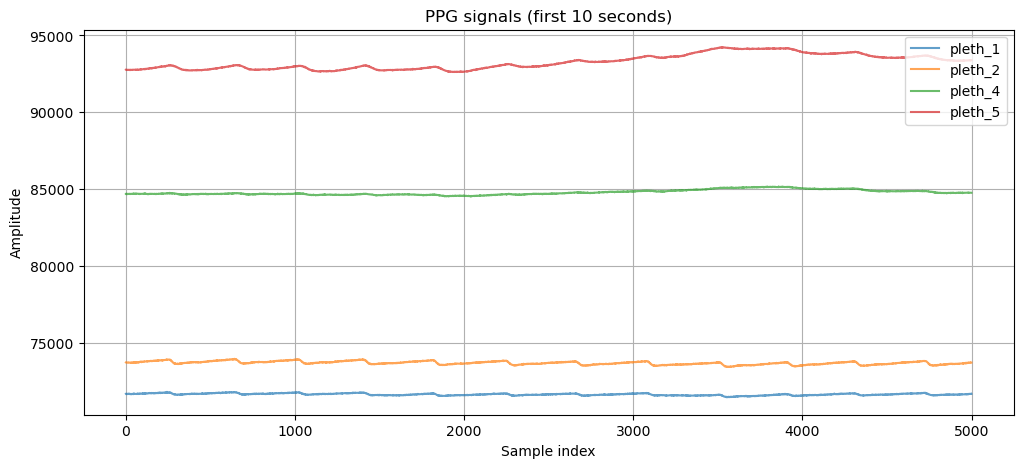

In [7]:
# Visualizing pleth_1 and pleth_2
plot_ppg(df, channels=['pleth_1', 'pleth_2', 'pleth_4', 'pleth_5'], seconds=10, fs=500)

## 2. Data Preprocessing

**Q. Why consider only `pleth_1` and `pleth_2` for SpO2 estimation?**

SpO2 is estimated from a photoplethysmograph (PPG) signal by comparing the absorption of **red** and **infrared** light by the blood, as oxygenated and deoxygenated hemoglobin absorb these wavelengths differently. This comparison is used to calculate the ratio of AC (pulsatile) to DC (non-pulsatile) components of the PPG signal from both light wavelengths, which is then used in an empirical equation to determine the SpO2 level.

`pleth_1` & `pleth_2` (distal, fingertip):
* Usually stronger pulsatile signals (more blood perfusion at fingertip).
* Commonly used in commercial pulse oximeters.
* Better for clean SpO₂ estimation.

`pleth_4` & `pleth_5` (proximal, finger base):
* Signals can be weaker or noisier because perfusion is lower compared to fingertip.
* Still useful for redundancy, or if fingertip signals are noisy.
* Could be used to test robustness of the model across sensor placements.

In [8]:
from preprocess import preprocess_ppg, plot_ppg_filtered

preprocessed_df = preprocess_ppg(df, channels=['pleth_1', 'pleth_2'], fs=500)
preprocessed_df.head()

,time,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,lc_1,...,temp_2,temp_3,a_x,a_y,a_z,g_x,g_y,g_z,pleth_1_filtered,pleth_2_filtered
0,2021-01-01 16:42:18.569309,30736,0,71695,73737,5743,84690,92770,6159,7099667,...,36.5,33.705544,4.298409,1.371349,-8.450766,0.007759,-0.000482,0.004583,-16.050261,-29.373734
1,2021-01-01 16:42:18.571309,30714,0,71680,73726,5752,84678,92759,6160,7099667,...,36.5,33.708538,4.309184,1.374940,-8.434005,0.006827,0.001249,0.004317,-16.450812,-29.986605
2,2021-01-01 16:42:18.573309,30703,0,71680,73726,5752,84678,92759,6160,7099667,...,36.5,33.708538,4.319360,1.371349,-8.436998,0.006161,0.001915,0.003385,-16.847362,-30.597708
3,2021-01-01 16:42:18.575309,30697,0,71693,73727,5743,84698,92762,6156,7101208,...,36.5,33.708538,4.318761,1.377933,-8.457949,0.005229,0.001515,0.001920,-17.239276,-31.206009
4,2021-01-01 16:42:18.577309,30698,0,71691,73722,5749,84690,92762,6165,7101208,...,36.5,33.708538,4.318761,1.382123,-8.484286,0.003498,0.000583,-0.000210,-17.625924,-31.810465


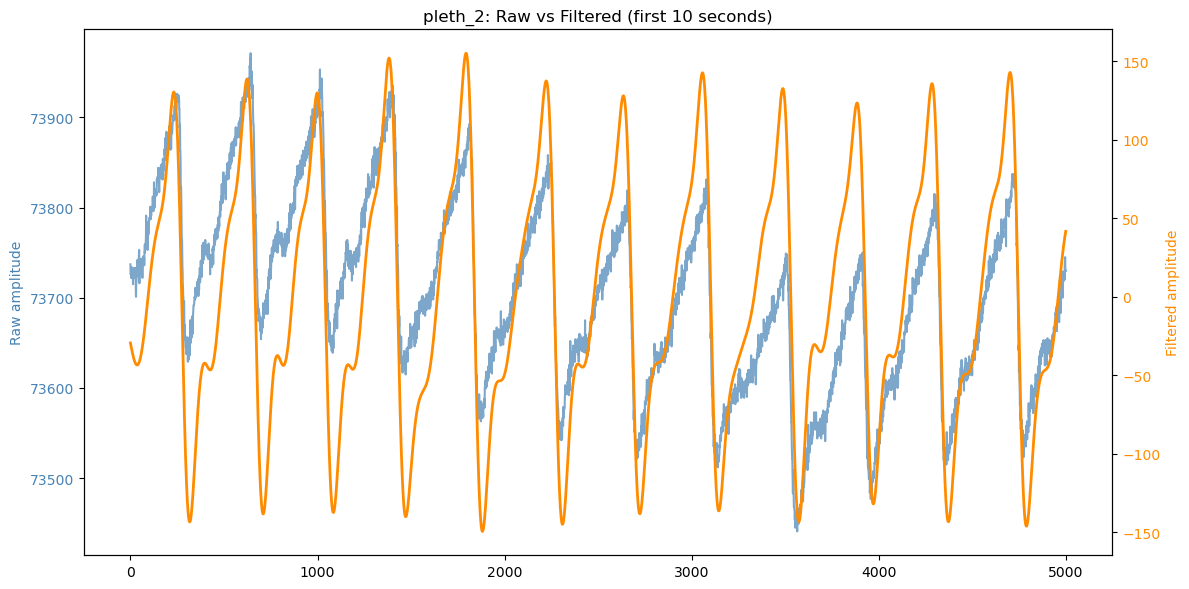

In [20]:
plot_ppg_filtered(df, channel='pleth_2', seconds=10)

## 3. Identifying Systolic Peaks, Dicrotic Notch, and Diastolic Peaks

### Physiological context: PPG waveform

The **photoplethysmography (PPG) waveform** reflects blood volume changes in the microvascular bed of tissue (often finger/ear sensors).
A single cardiac cycle produces a characteristic shape:

* **Systolic peak (main peak):**
  The tallest peak in the waveform. It corresponds to the maximum blood volume during **systole** (when the heart contracts and pumps blood into the arteries).

* **Dicrotic notch:**
  A small downward deflection after the systolic peak. It’s associated with **aortic valve closure** and the beginning of diastole.

* **Diastolic peak (secondary peak):**
  A smaller “second bump” after the dicrotic notch, representing reflective waves in the arterial system during **diastole**.

So each cycle looks like:
Rise → **Systolic peak** → Dip (**Dicrotic notch**) → Small **Diastolic peak**.

* **Heart rate:**
  Heart rate is derived from systolic-to-systolic spacing.
  
  Compute distance between consecutive systolic peaks -> divide by fs and convert to seconds (RR interval = time between beats)
  
  HR = 60 / mean(RR interval) → beats per minute.


In [10]:
from feature_extraction import build_feature_dataframe

df_features = build_feature_dataframe(preprocessed_df["pleth_2_filtered"], fs=500)
df_features.head()

,sys_idx,notch_idx,dia_idx,systolic_amp,notch_amp,diastolic_amp,systolic_time,notch_time,diastolic_time,rise_time,pulse_width,heart_rate_bpm
0,232,317,622,130.442637,-143.344766,138.633664,0.464,0.634,1.244,0.170,0.780,72.424607
1,623,710,998,138.751961,-138.237787,129.862793,1.246,1.420,1.996,0.174,0.750,72.424607
2,999,1085,1382,129.882605,-137.301762,152.003155,1.998,2.170,2.764,0.172,0.766,72.424607
3,1383,1472,1793,152.013533,-139.994831,155.060627,2.766,2.944,3.586,0.178,0.820,72.424607
4,1794,1882,2221,155.130481,-149.345461,137.367284,3.588,3.764,4.442,0.176,0.854,72.424607


In [11]:
df_features["heart_rate_bpm"].max(), df_features["heart_rate_bpm"].min(), df_features["heart_rate_bpm"].value_counts()

(72.42460700972367,
 72.42460700972367,
 heart_rate_bpm
 72.424607    612
 Name: count, dtype: int64)

## 4. SpO2 Estimation

* Typically, IR (pleth\_2) has a **stronger signal-to-noise ratio** in finger PPG → so it’s common to use **pleth\_2\_filtered** for peak detection.
* Then apply those systolic indices to **both pleth\_1\_filtered (Red)** and **pleth\_2\_filtered (IR)** when computing AC/DC ratios.


In [12]:
systolic_peaks = df_features["sys_idx"].values  

# create beat intervals (start, end)
beat_intervals = [(systolic_peaks[i], systolic_peaks[i+1]) for i in range(len(systolic_peaks)-1)]

In [13]:
from spo2_extraction import extract_spo2_features

spo2_extracted_df = extract_spo2_features(red_signal=preprocessed_df["pleth_1_filtered"],
                                          ir_signal=preprocessed_df["pleth_2_filtered"],
                                          beats=beat_intervals)

spo2_extracted_df.head()

,beat_idx,R_ratio,SpO2_est
0,0,1.080977,82.975573
1,1,0.113841,107.153977
2,2,1.325817,76.854587
3,3,-0.279589,116.989720
4,4,-0.712608,127.815194


In [16]:
# Keeping only those spo2 values that range between 70 and 100
usable_df = spo2_extracted_df.copy()
usable_df = usable_df[(usable_df["SpO2_est"] >= 70) & (usable_df["SpO2_est"] <= 100)]
usable_df = usable_df[(usable_df["R_ratio"] > 0.3) & (usable_df["R_ratio"] < 1.2)]
usable_df = usable_df.reset_index(drop=True)
usable_df.head()

,beat_idx,R_ratio,SpO2_est
0,0,1.080977,82.975573
1,7,0.610418,94.739553
2,9,0.697020,92.574501
3,10,0.525742,96.856452
4,11,0.803722,89.906953


In [19]:
usable_df["SpO2_est"].mean()

89.42329830945857